# Traveling Salesman Problem
The Traveling Salesman Problem (TSP) concerns finding the shortest path that a traveling salesman can take to go through a list of cities in the shortest time possible. This problem is represented in a graph $G =(V,E)$. Each vertex in the graph $G$ represents a different camp, while the weights on each of the edges $(u,v)$ represent the distance between the two camps $u$ and $v$. 

This is an NP-Hard problem, and there is no known classical algorithm that is know to solve this problem in linear time. 


# Installing Dependencies

In [ ]:
# installing necessary modules
! pip install networkx
! pip install qibo --user

# Introductory Challenge  

The initial task in this challenge requires you to determine a Hamiltonian that can effectively solve the Traveling Salesman Problem (TSP). 
To achieve this, a set of functions has been provided for you to complete, enabling you to find the solution using both Quantum Alternating Operator Ansatz (QAOA) and Adiabatic Quantum Optimization (AQO).

To solve this challenge, you will need to accomplish the following tasks:
1. Construct the cost, mixer, and initial Symbolic Hamiltonians that will be used for QAOA and AQO.
2. Prepare a suitable initial state for the system.
3. print and visualize your results. 
4. calculate the Fidelity of your results for both QAOA and AQO. 

## Graph construction

We first have to define the different camps and distances using a graph. Here you can find the definition of these camps:

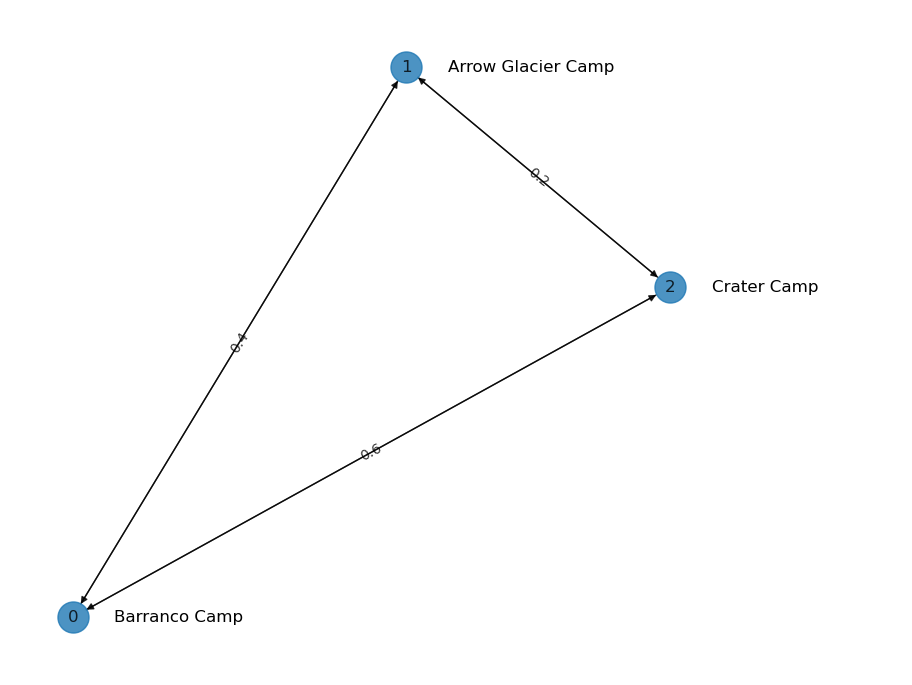

In [91]:
import matplotlib.pylab as plt
import networkx as nx
import numpy as np 

# define a directed graph 
G = nx.DiGraph()

# define the edges of the graph with their corresponding weights
G.add_edge(0, 1, weight=0.4)
G.add_edge(1, 0, weight=0.4)

G.add_edge(0, 2, weight=0.6)
G.add_edge(2, 0, weight=0.6)

G.add_edge(1, 2, weight=0.2)
G.add_edge(2, 1, weight=0.2)


# save the labels of the various edges to be able to plot them.
edge_labels= {}
for (u,v) in G.edges():
    edge_labels[(u,v)] = G[u][v]["weight"]

pos = {0: np.array([-0.3, -0.3 ]), 1: np.array([-0.06 ,  0.2]), 2: np.array([0.13, 0. ])}

# creating node labels
labels = {}
labels[0] = 'Barranco Camp'
labels[1] = 'Arrow Glacier Camp'
labels[2] = 'Crater Camp'

# applying a shift to the node labels for readability purposes 
shift = np.array([0.03, 0])
shifted_pos ={node: node_pos + shift for (node, node_pos) in pos.items()}

# draw node labels
nx.draw_networkx_labels(G, shifted_pos, labels=labels, horizontalalignment="left")


#plot the graph and the edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, alpha=0.8)
nx.draw(G, pos, with_labels=True, alpha=0.8, node_size=500)

# adjust frame to avoid cutting text, may need to adjust the value
axis = plt.gca()
lim = axis.get_xlim()
axis.set_xlim([lim[0], lim[1] * 1.7])

# increase the size of the figure
figure_size = plt.gcf().get_size_inches()
factor = 1.8
plt.gcf().set_size_inches(factor * figure_size)

plt.show()


## Solution 

In [ ]:
def graphComplete(G: nx.DiGraph) -> nx.DiGraph:
    maxWt = 0
    for (u, v, wt) in G.edges.data('weight'):
        maxWt = max(maxWt, wt)

    maxWt += 10
    for i in range(n):
        for j in range(i):
            if not G.has_edge(i,j):
                G.add_edge(i, j, maxWt)

    return G

In [60]:
def complete_graph(G_: nx.DiGraph):
    """ Make the graph fully connected by adding edge with the maximum weight """
    G = G_.copy()
    max_weight = max([G[u][v]["weight"] for (u,v) in G.edges()])
    # copy G
    for node in G.nodes():
        for other_node in G.nodes():
            if node != other_node and not G.has_edge(node, other_node):
                G.add_edge(node, other_node, weight=max_weight)
    return G
    

In [131]:
from qibo.symbols import X, Y, Z
from qibo import hamiltonians
import sympy

def get_nbits(G):
    """ Returns the number of bits needed to encode the graph. """
    if type(G) == nx.DiGraph:
        return int(np.ceil(np.log2(G.number_of_nodes())))
    elif type(G) == int:
        return int(np.ceil(np.log2(G)))

def to_binary(number: int, length: int) -> str :
    return format(number, f'0{length}b')

def from_binary(bitstring: str) -> int:
    return int(bitstring, 2)

def binenc(number: int, n: int):
    """ Return the binary encoding of number with n bits. """
    return np.array([int(x) for x in bin(number)[2:].zfill(n)])

def basisenc(number: int, n: int):
    bitstring = binenc(number, n)
    qubitlist = [[0, 1] if bit == 0 else [1, 0] for bit in bitstring]
    res = qubitlist[0]
    for qubit in qubitlist[1:]:
        res = np.kron(res, qubit)
    return res

def get_bit(qubit: int) -> sympy.Expr:
    return (1 - Z(qubit))/2

bitMapping = {
    "0": lambda idx: (1 - get_bit(idx)),
    "1": lambda idx: get_bit(idx)
}

def project(A: int, i: int, n_bits: int) -> sympy.Expr:
    """ Projector over state |A>_i in a space of n_bits qubits, where i is the timestep idx """
    A_b = to_binary(number = A, length = n_bits)
    startIdx = i * n_bits

    H_i = 1
    for bitidx, bit in enumerate(A_b):
        H_i *= bitMapping[bit](startIdx + bitidx)

    return H_i


def swap1d(A: int, B: int, i: int, n_bits: int):
    """ Swap cities |A>_i and |B>_i at time i in a space of n qubits. """
    A_b = to_binary(number = A, length = n_bits)
    B_b = to_binary(number = B, length = n_bits)

    startIdx = i * n_bits
    
    H_i = 1
    for bitidx in range(n_bits):
        if A_b[bitidx] != B_b[bitidx]:
            H_i *= X(startIdx + bitidx)

    return H_i


def swap(A: int, B: int, i: int, j: int, n_bits: int) -> sympy.Expr:
    """ Swap cities |A>_i and |B>_j at times i and j in a space of n qubits. """
    return swap1d(A, B, i, n_bits) * swap1d(B, A, j, n_bits)

def build_constraint_hamiltonian(G : nx.Graph, n_bits: int) -> hamiltonians.SymbolicHamiltonian:
    """ Builds the constraints that characterize viable solutions (H1 + H2). """
    H1 = 0
    n = G.number_of_nodes()
    for alpha in range(n):
        term = sum([project(alpha, j, n_bits) for j in range(n)])
        H1 += (1 - term) ** 2
    H2 = 0
    for j in range(n):
        term = sum([project(alpha, j, n_bits) for alpha in range(n)])
        H2 += (1 - term) ** 2
    return H1 + H2

def build_TSP_hamiltonian(G : nx.Graph, k=4) ->  hamiltonians.SymbolicHamiltonian:
    '''
    build the cost hamiltonian.

    args: 
        G: a networkx graph
            the graph representing the camp distribution. 
            
    
    returns:
        The symbolic cost hamiltonian of the TSP with respect to the nodes specified in the graph
    '''

    H: sympy.Expr = 0

    nNodes: int = G.number_of_nodes() # this assumes start point can be any node
    nTimeSteps: int = nNodes
    nBits:  int = int(np.ceil(np.log2(nNodes))) # required per timestep to describe the city

    for (u, v, wt) in G.edges.data('weight'):
        u_b: str = to_binary(u, nBits)
        v_b: str = to_binary(v, nBits)

        uv_b: str = u_b + v_b

        # print(u, v, wt, u_b, v_b)

        for i in range(nTimeSteps - 1):
            # We look at every set of nodes and create the necessary operator
            H += project(u, i, nBits) * project(v, i + 1, nBits) * wt
            continue
            startIdx = i * nBits
            H_i = 1
            for bitidx, bit in enumerate(uv_b):
                H_i *= bitMapping[bit](startIdx + bitidx)

            # print(sympy.latex(H_i))

            H += wt * H_i

    # print(sympy.latex(H))
    H12 = build_constraint_hamiltonian(G, nBits)
    res = hamiltonians.SymbolicHamiltonian(form = (H + k*H12))
    return res

# hamiltonian = build_TSP_hamiltonian(G)

def build_mixer_hamiltonian(G: nx.Graph) ->  hamiltonians.SymbolicHamiltonian:
    '''
    build the mixer hamiltonian for the quantum alternating operator ansatz (QAOA).

    args:
        G: a networkx graph
            the graph representing the camp distribution. 

    returns:
        The symbolic mixer hamiltonian of the TSP with respect to the nodes specified in the graph

    '''
    # form : sympy.Expr = 
    # return hamiltonians.SymbolicHamiltonian(form = form)
    return x_mixer(G)

def optimal_mixer(G: nx.Graph):
    n_bits = get_nbits(G)
    n = G.number_of_nodes()
    mixer_operators = []
    for t in range(n-1):
        for A in range(n):
            for B in range(n):
                i = t
                first_part = swap(A, B, i, i+1, n_bits)
                second_part = swap(B, A, i, i+1, n_bits)
                mixer_operators.append(first_part + second_part)
    H = sum(mixer_operators)
    return hamiltonians.SymbolicHamiltonian(form = H)

def x_mixer(G: nx.Graph):
    n_bits = get_nbits(G)
    sham = sum((X(i)) for i in range(G.number_of_nodes() * n_bits)) 
    return hamiltonians.SymbolicHamiltonian(sham)

def build_initial_hamiltonian(G: nx.Graph) ->  hamiltonians.SymbolicHamiltonian:
    '''
    build the initial hamiltonian for the adiabatic quantum optimization (AQO).

    args:
        G: a networkx graph
            the graph representing the camp distribution. 

    returns:
        A symbolic hamiltonian representing the initial hamiltonian that will be used in the adiabatic optimization. 

    '''
    
    pass

def prepare_initial_state(G: nx.Graph, start=None, end=None):
    '''
    prepare the initial state of the system.

    Initial state is some sequence of cities

    args:
        G: a networkx graph
            the graph representing the camp distribution. 
        start: Union[int, None]
            The starting city. If None, then the starting city is chosen at random.
        end: Union[int, None]
            The ending city. If None, then the ending city is chosen at random.

    returns:
        The initial state of the system.

    '''
    # create a list of all the nodes starting from start and ending at end
    node_list = list(G.nodes)
    random_start, random_end = np.random.choice(node_list, 2, replace=False)
    if start is None:
        start = random_start
    if end is None:
        end = random_end
    node_list.remove(start)
    node_list.remove(end)
    node_list = [start] + node_list + [end]
    # each node is converted to tensor binenc(node). Result is the kronecker product of all the nodes
    n_bits = get_nbits(G)
    res = basisenc(node_list[0], n_bits)
    for node in node_list[1:]:
        res = np.kron(res, basisenc(node, n_bits))
    return res
    # 

def display_solution(state: str, n_nodes: int):
    '''
    display the solution of the TSP.

    args:
       r, n_nodes: int, n_nodes: intstate: string 
            A string encoding the TSP solution
     
    '''
    
    l = len(state)
    n_bits_per_node = int(l / n_nodes)
    num_timesteps = n_nodes

    sequence = []
    for i in range(num_timesteps):
        node = from_binary(state[i * n_bits_per_node:(i + 1) * n_bits_per_node])
        sequence.append(node)

    print(sequence)

In [120]:
hamiltonian.circuit(1).summary()

'Circuit depth = 6\nTotal number of gates = 6\nNumber of qubits = 6\nMost common gates:\nUnitary: 6'

## Quantum Alternating Operator Ansatz (QAOA)

In [114]:
import numpy as np
from qibo import models, hamiltonians


nqubits = G.number_of_nodes() * get_nbits(G)
print("number of qubits needed to solve the problem: ", nqubits)

# create the cost Hamiltonian for the given graph
hamiltonian = build_TSP_hamiltonian(G, k=3)

# create the mixer Hamiltonian for the given graph
mixer_hamiltonian = build_mixer_hamiltonian(G)

# create QAOA model given the Hamiltonians
qaoa = models.QAOA(hamiltonian=hamiltonian, mixer=mixer_hamiltonian)

# optimize using random initial variational parameters with eight layers 
# Note: you can change the number of layers but it has to be an even number
num_layers = 4
initial_parameters = np.random.random(num_layers) 

# prepare the initial state of the QAOA optimization 
initial_state = prepare_initial_state(complete_graph(G)) 

print("eigenvalues", hamiltonian.dense.eigenvalues())

# run the QAOA optimization with the initial parameters and the hamiltonians defined
best_energy, final_parameters, extra = qaoa.minimize(
    initial_parameters, 
    method="BFGS", 
    initial_state=initial_state)

print("best energy: ", best_energy)

[Qibo 0.1.13|WARNING|2023-05-07 05:56:59]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


number of qubits needed to solve the problem:  6
eigenvalues tf.Tensor(
[ 0.6+0.j  0.6+0.j  0.8+0.j  0.8+0.j  1. +0.j  1. +0.j  6. +0.j  6. +0.j
  6. +0.j  6. +0.j  6. +0.j  6. +0.j  6.2+0.j  6.2+0.j  6.2+0.j  6.2+0.j
  6.2+0.j  6.2+0.j  6.2+0.j  6.2+0.j  6.4+0.j  6.4+0.j  6.4+0.j  6.4+0.j
  6.4+0.j  6.4+0.j  6.4+0.j  6.4+0.j  6.4+0.j  6.4+0.j  6.6+0.j  6.6+0.j
  6.6+0.j  6.6+0.j  6.6+0.j  6.6+0.j  6.6+0.j  6.6+0.j  6.8+0.j  6.8+0.j
  7.2+0.j  7.2+0.j 12. +0.j 12. +0.j 12. +0.j 12. +0.j 12. +0.j 12. +0.j
 12. +0.j 12. +0.j 12. +0.j 12. +0.j 12. +0.j 12. +0.j 12. +0.j 12. +0.j
 12. +0.j 12. +0.j 12. +0.j 12. +0.j 18. +0.j 18. +0.j 18. +0.j 18. +0.j], shape=(64,), dtype=complex128)
best energy:  0.8000000000000966


## Adiabatic Quantum Optimization

In [ ]:
import numpy as np
from qibo.models.evolution import AdiabaticEvolution
from qibo.hamiltonians.hamiltonians import Hamiltonian

# build initial (H0) and target (H1) hamiltonians
H1 = build_TSP_hamiltonian(G)
H0 = build_initial_hamiltonian(G)

dt = 0.1
nqubits = (G.number_of_nodes()) ** 2

# calculate the dense hamiltonian from the symbolic hamiltonian
H1_dense = Hamiltonian(nqubits, H1.matrix)
H0_dense = Hamiltonian(nqubits, H0.matrix)

# define the scheduler
def s(t): return t



# construct the adiabatic model
adiabatic_model = AdiabaticEvolution(H0_dense, H1_dense, s, dt)

In [ ]:
# execute the adiabatic optimization
adiabatic_quantum_state = adiabatic_model.execute(final_time=T) 

# obtain the state with the highest probability
solution_dec = (np.abs(adiabatic_quantum_state) ** 2).argmax()

adiabatic_solution = "{0:0{bits}b}".format(solution_dec, bits=nqubits)

display_solution(adiabatic_solution) # adiabatic solution is a binary string containing the solution

# Real Life Challenges 

In this challenge, you will be tasked with solving TSP for an extended graph on a quantum computer that has a limited number of qubits. Specifically, the quantum computer will only have 6 qubits available. Moreover, the extended graph includes two new nodes a starting and ending locations. Your solution must begin at the starting point which is Karanga Camp and end at the Kibo peak.

To solve this challenge, you will need to accomplish the following tasks:

1. Design and build a new Hamiltonian that takes into account the lack of qubits and the addition of the two new nodes.
2. Calculate and analyze the fidelity of both the AQO and QAOA solutions.
3. Experiment with different scheduling strategies to improve the fidelity of your solution.

It is important that you document the steps you follow and your findings in a clear and concise manner. Good luck!

## Graph construction 

In [151]:
def build_lTSP_hamiltonian(G: nx.Graph, k: int) -> hamiltonians.SymbolicHamiltonian:
    H = 0
    nNodes = G.number_of_nodes() # this assumes start point can be any node
    nTimeSteps: int = nNodes-2
    nBits:  int = int(np.ceil(np.log2(nNodes-2))) # required per timestep to describe the city

    for (u, v, wt) in G.edges.data('weight'):
        A, B = u-1, v-1
        if u == 0:
            H += project(B, 0, nBits) * wt
            continue
        if v == nNodes-1:
            H += project(A, nNodes-3, nBits) * wt
            continue
        if u == 0 or v == 0 or u == nNodes - 1 or v == nNodes - 1:
            continue
        for i in range(nTimeSteps - 1):
            # We look at every set of nodes and create the necessary operator
            H += project(A, i, nBits) * project(B, i + 1, nBits) * wt

    # print(sympy.latex(H))
    redG = G.copy()
    redG.remove_node(0)
    redG.remove_node(nNodes-1)
    H12 = build_constraint_hamiltonian(redG, nBits)
    res = hamiltonians.SymbolicHamiltonian(form = (H + k*H12))
    return res

def prepare_initial_state(G: nx.Graph):
    # create a list of all the nodes starting from start and ending at end
    n = G.number_of_nodes()
    node_list = list(range(n-2))
    # each node is converted to tensor binenc(node). Result is the kronecker product of all the nodes
    n_bits = get_nbits(G.number_of_nodes()-2)
    res = basisenc(node_list[0], n_bits)
    for node in node_list[1:]:
        res = np.kron(res, basisenc(node, n_bits))
    return res

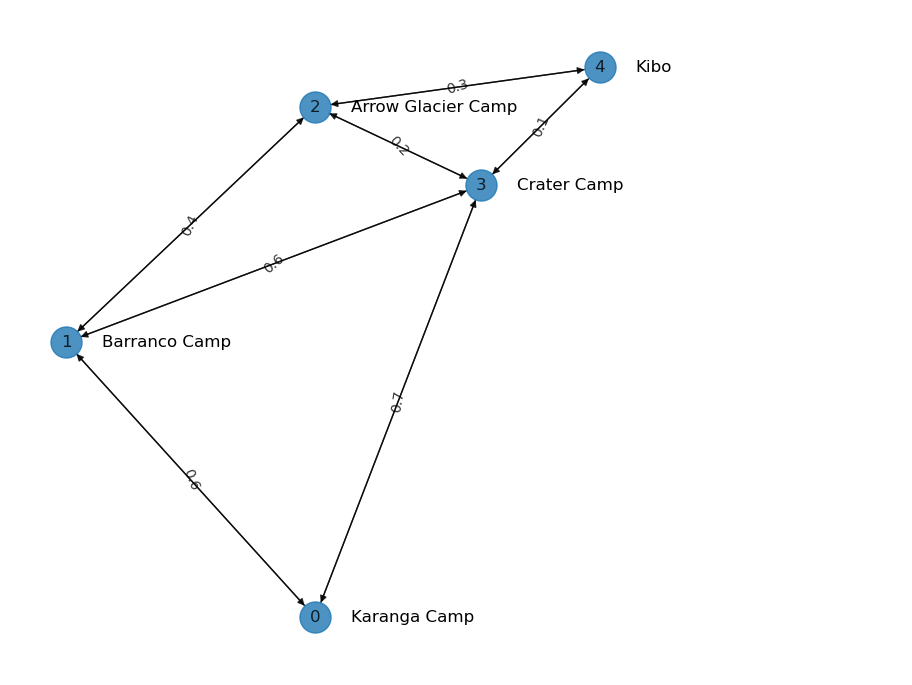

In [121]:
import matplotlib.pylab as plt
import networkx as nx
import numpy as np 

# define a directed graph 
G = nx.DiGraph()

# define the edges of the graph with their corresponding weights
G.add_edge(0, 1, weight=0.6)
G.add_edge(1, 0, weight=0.6)

G.add_edge(0, 3, weight=0.7)
G.add_edge(3, 0, weight=0.7)

G.add_edge(1, 3, weight=0.6)
G.add_edge(3, 1, weight=0.6)

G.add_edge(1, 2, weight=0.4)
G.add_edge(2, 1, weight=0.4)

G.add_edge(2, 3, weight=0.2)
G.add_edge(3, 2, weight=0.2)

G.add_edge(3, 4, weight=0.1)
G.add_edge(4, 3, weight=0.1)

G.add_edge(2, 4, weight=0.3)
G.add_edge(4, 2, weight=0.3)


# save the labels of the various edges to be able to plot them.
edge_labels= {}
for (u,v) in G.edges():
    edge_labels[(u,v)] = G[u][v]["weight"]

pos = {0: np.array([0.01, -1 ]), 1: np.array([-0.2, -0.3 ]), 2: np.array([0.01 ,  0.3]), 3: np.array([0.15, 0.1 ]), 4: np.array([0.25, 0.4 ])}

# creating node labels
labels = {}
labels[0] = 'Karanga Camp'
labels[1] = 'Barranco Camp'
labels[2] = 'Arrow Glacier Camp'
labels[3] = 'Crater Camp'
labels[4] = 'Kibo'

# applying a shift to the node labels for readability purposes 
shift = np.array([0.03, 0])
shifted_pos ={node: node_pos + shift for (node, node_pos) in pos.items()}

# draw node labels
nx.draw_networkx_labels(G, shifted_pos, labels=labels, horizontalalignment="left")


#plot the graph and the edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, alpha=0.8)
nx.draw(G, pos, with_labels=True, alpha=0.8, node_size=500)

# adjust frame to avoid cutting text, may need to adjust the value
axis = plt.gca()
lim = axis.get_xlim()
axis.set_xlim([lim[0], lim[1] * 1.7])

# increase the size of the figure
figure_size = plt.gcf().get_size_inches()
factor = 1.8
plt.gcf().set_size_inches(factor * figure_size)

plt.show()


## Solution 

In [154]:
import numpy as np
from qibo import models, hamiltonians


nqubits = (G.number_of_nodes() - 2) * get_nbits(G.number_of_nodes()-2)
print("number of qubits needed to solve the problem: ", nqubits)

# create the cost Hamiltonian for the given graph
hamiltonian = build_lTSP_hamiltonian(complete_graph(G), k=3)

# create the mixer Hamiltonian for the given graph
def build_mixer_hamiltonian(G):
    sham = sum((X(i)) for i in range(nqubits)) 
    return hamiltonians.SymbolicHamiltonian(sham)
mixer_hamiltonian = build_mixer_hamiltonian(G)

# create QAOA model given the Hamiltonians
qaoa = models.QAOA(hamiltonian=hamiltonian, mixer=mixer_hamiltonian)
# optimize using random initial variational parameters with eight layers 
# Note: you can change the number of layers but it has to be an even number
num_layers = 8
initial_parameters = np.random.random(num_layers) 

# prepare the initial state of the QAOA optimization 
initial_state = prepare_initial_state(complete_graph(G)) 

print("eigenvalues", hamiltonian.dense.eigenvalues())

# run the QAOA optimization with the initial parameters and the hamiltonians defined
best_energy, final_parameters, extra = qaoa.minimize(
    initial_parameters, 
    method="BFGS", 
    initial_state=initial_state)

print("best energy: ", best_energy)

[Qibo 0.1.13|WARNING|2023-05-07 07:37:54]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


number of qubits needed to solve the problem:  6
eigenvalues tf.Tensor(
[ 1.3+0.j  1.7+0.j  1.8+0.j  2. +0.j  2. +0.j  2.2+0.j  6.7+0.j  6.8+0.j
  6.9+0.j  6.9+0.j  6.9+0.j  7. +0.j  7. +0.j  7. +0.j  7. +0.j  7. +0.j
  7.1+0.j  7.2+0.j  7.2+0.j  7.2+0.j  7.2+0.j  7.2+0.j  7.3+0.j  7.3+0.j
  7.3+0.j  7.3+0.j  7.3+0.j  7.4+0.j  7.4+0.j  7.4+0.j  7.4+0.j  7.4+0.j
  7.8+0.j  7.8+0.j  7.8+0.j  7.8+0.j  8. +0.j  8. +0.j  8. +0.j  8. +0.j
  8.1+0.j  8.5+0.j 12.6+0.j 12.6+0.j 12.7+0.j 12.7+0.j 12.7+0.j 12.7+0.j
 12.7+0.j 12.7+0.j 12.7+0.j 12.8+0.j 12.8+0.j 12.8+0.j 13. +0.j 13. +0.j
 13. +0.j 13.3+0.j 13.4+0.j 13.4+0.j 18.7+0.j 18.8+0.j 19. +0.j 19.3+0.j], shape=(64,), dtype=complex128)
best energy:  1.300000000000004


In [149]:
best_energy

1.3000000000014418